In [1]:
!unzip '/content/hw3.zip'

Archive:  /content/hw3.zip
  inflating: HW3.tex                 
  inflating: __MACOSX/._HW3.tex      
   creating: datasets/
  inflating: __MACOSX/._datasets     
  inflating: datasets/hw3_cancer.csv  
  inflating: __MACOSX/datasets/._hw3_cancer.csv  
  inflating: datasets/hw3_house_votes_84.csv  
  inflating: __MACOSX/datasets/._hw3_house_votes_84.csv  
  inflating: datasets/hw3_wine.csv   
  inflating: __MACOSX/datasets/._hw3_wine.csv  
   creating: figures/
  inflating: figures/cross_val_stratified2.png  
  inflating: __MACOSX/figures/._cross_val_stratified2.png  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

In [31]:
class DT_gini:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def gini(self, labels):
        _, counts = np.unique(labels, return_counts=True)
        return 1 - np.sum((counts / counts.sum())**2)

    def split_data(self, features, labels, feature, split_value):
        left_mask = features[feature] <= split_value
        right_mask = features[feature] > split_value
        return labels[left_mask], labels[right_mask]

    def calculate_split_gini(self, left_labels, right_labels):
        left_gini = self.gini(left_labels)
        right_gini = self.gini(right_labels)
        total = len(left_labels) + len(right_labels)
        weighted_gini = (len(left_labels) / total) * left_gini + (len(right_labels) / total) * right_gini
        return weighted_gini

    def best_split(self, features, labels, feature_types):
        best_gini = np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            if feature_types[feature] == 'numerical':
                sorted_vals = np.sort(features[feature].unique())
                split_values = (sorted_vals[:-1] + sorted_vals[1:]) / 2
                for split_value in split_values:
                    left_labels, right_labels = self.split_data(features, labels, feature, split_value)
                    avg_gini = self.calculate_split_gini(left_labels, right_labels)
                    if avg_gini < best_gini:
                        best_gini = avg_gini
                        best_feature = feature
                        best_split_val = split_value
            else:
                avg_gini = self.gini_impurity(labels, features[feature])
                if avg_gini < best_gini:
                    best_gini, best_feature = avg_gini, feature
                    best_split_val = None

        return best_feature, best_split_val

    def gini_impurity(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        return sum((counts[i] / sum(counts)) * self.gini(labels[partitions == value]) for i, value in enumerate(values))

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or depth == self.max_depth:
            most_common_label = Counter(labels).most_common(1)[0][0]
            return most_common_label
        best_feature, best_split_val = self.best_split(features, labels, feature_types)
        if best_feature is None:
            return np.unique(labels)[np.argmax(np.bincount(labels))]
        tree = {}
        if best_split_val is not None:
            left_indices = features[best_feature] <= best_split_val
            right_indices = features[best_feature] > best_split_val
            left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
            right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
            tree[best_feature] = {f"<= {best_split_val}": left_subtree, f"> {best_split_val}": right_subtree}
        else:
            tree[best_feature] = {}
            for value in np.unique(features[best_feature]):
                subtree_features = features[features[best_feature] == value]
                subtree_labels = labels[features[best_feature] == value]
                subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                tree[best_feature][value] = subtree
        return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = [self.predict_helper(instance, self.tree) for _, instance in dataset.iterrows()]
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree

        feature = next(iter(tree))
        if self.feature_types[feature] == 'numerical':
            for key, value in tree[feature].items():
                threshold = float(key.split(' ')[1])
                if (key.startswith('<=') and instance[feature] <= threshold) or (key.startswith('>') and instance[feature] > threshold):
                    return self.predict_helper(instance, value)
        else:
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])

        return np.nan


In [32]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT_gini(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [33]:
def stratified_cross_validation(features, labels, k=10):
    y = labels.to_numpy()
    label_indices = [np.where(y == label)[0] for label in np.unique(y)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [34]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [35]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf


#Analyzing the Wine Dataset

In [8]:
wine_dataset = pd.read_csv('datasets/hw3_wine.csv', delimiter='\t')
wine_dataset.head()

,# class,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [9]:
wine_dataset.columns = ['class'] + ['attribute' + str(i) for i in range(1, 14)]
num_instances = len(wine_dataset)
wine_features = wine_dataset.drop('class', axis=1)
wine_labels = wine_dataset['class']
wine_feature_types = {f'attribute{i}': 'numerical' for i in range(1, 14)}

In [36]:
average_performance_1 = evaluate_rf(wine_features, wine_labels, wine_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_1}")

Metrics for a value of ntree = 1: {'accuracy': 0.9107155142758858, 'precision': 0.9394660894660894, 'recall': 0.9084126984126986, 'f1': 0.9094965274377038}


In [16]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(wine_features, wine_labels, wine_feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.9038054695562435, 'precision': 0.9179232804232804, 'recall': 0.904484126984127, 'f1': 0.9031191031191032}
Metrics for a value of ntree = 5: {'accuracy': 0.9770833333333332, 'precision': 0.9774603174603176, 'recall': 0.9801587301587302, 'f1': 0.9778203278203279}
Metrics for a value of ntree = 10: {'accuracy': 0.9551535087719298, 'precision': 0.9636243386243388, 'recall': 0.9574206349206349, 'f1': 0.9567849742849743}
Metrics for a value of ntree = 20: {'accuracy': 0.9770833333333332, 'precision': 0.9793650793650794, 'recall': 0.980952380952381, 'f1': 0.9777000777000776}
Metrics for a value of ntree = 30: {'accuracy': 0.9774509803921567, 'precision': 0.9782539682539684, 'recall': 0.9801587301587302, 'f1': 0.9777814777814777}
Metrics for a value of ntree = 40: {'accuracy': 0.9770833333333334, 'precision': 0.9785714285714286, 'recall': 0.980952380952381, 'f1': 0.9776612276612276}
Metrics for a value of ntree = 50: {'accuracy': 0.9721878224974

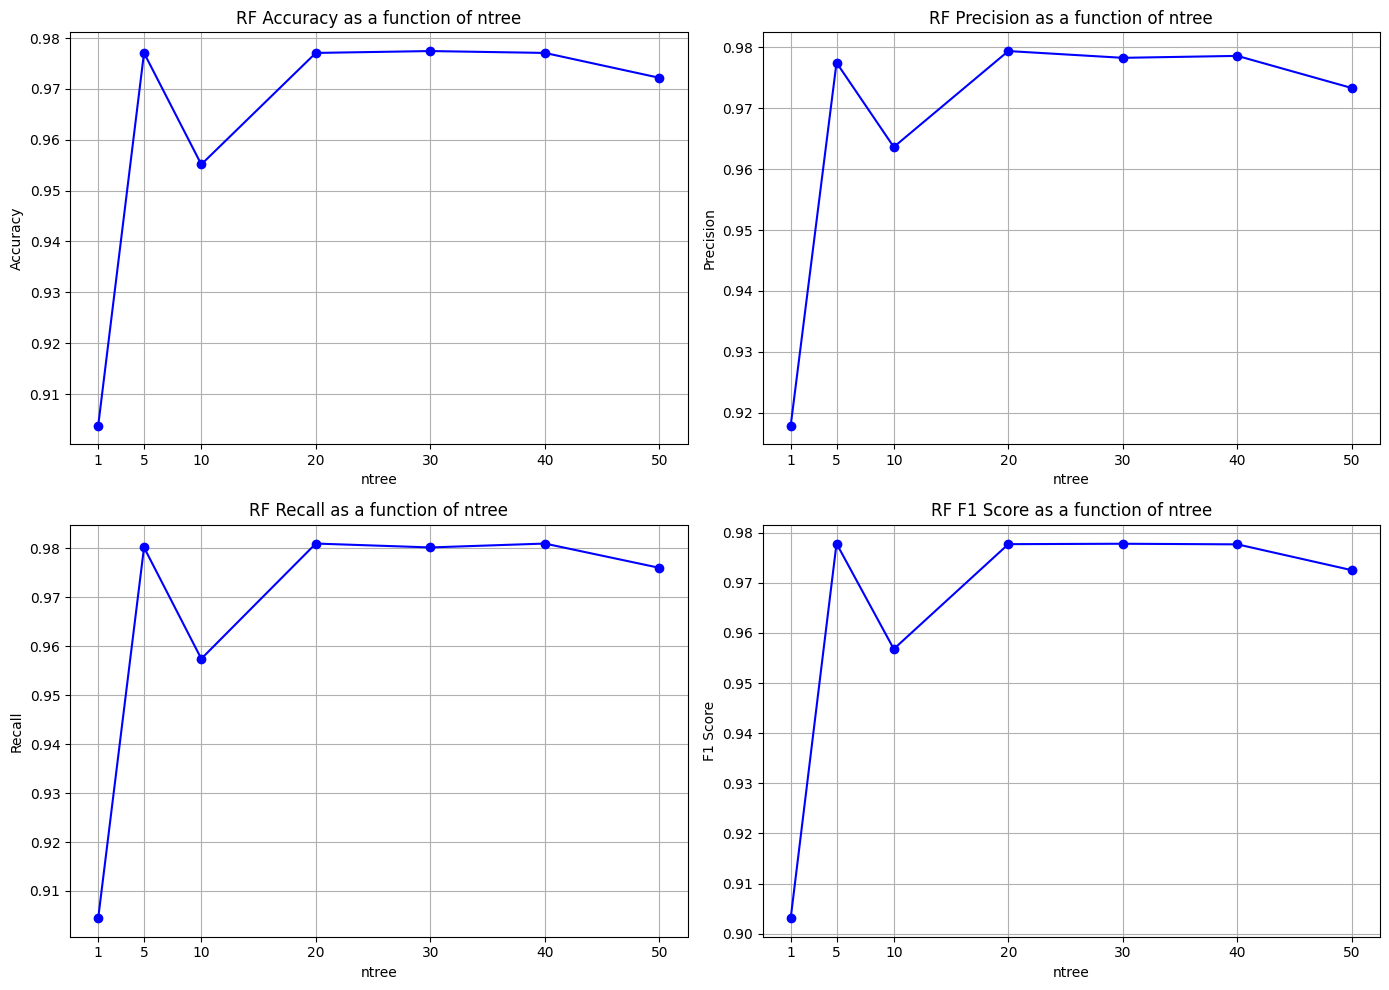

In [17]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)

**4.** For each metric being evaluated (and for each dataset), discuss which value of ntree you would
select if you were to deploy this classifier in real life. Explain your reasoning.

In this section of this notebook, we are analyzing the Wine Dataset (gini criterion). The presented metrics reflect the model's performance across different values of ntree for accuracy, precision, recall, and F1 score. Our goal is to identify the optimal ntree value that best enhances these performance metrics.  Let's discuss for each metric being evaluated what value of ntree we would select if we were to deplot this in real life:

For accuracy ntree = 5 and 20 both yield the highest accuracy of approximately 0.977, this indicates that the model is effective across both classes of wine.  If this a bigger dataset computational efficiency would play a part in choosing the value of ntree that we would choose, but given the small dataset size it's not a big concern for us, making both 5 and 20 good options. However, ntree = 20 shows consistently high performance across other metrics too so it would be the better option here.

For precision ntree = 20 shows slightly higher precision than the other values. Having a high precision in this case as mentioned in the earlier notebook, indicates that when the model predicts a wine class, it is correct more often. In some scenarios  incorrectly classifying a wine type could have negative implications so we need a higher precision.

Recall reaches it's highest for ntree = 20 but it's really close in for a value of ntree = 5 and 30. They all somewhat achieve the same recall, and this is important for identifying all relevant instances of each wine class. If we're recommending wine we don't want to miss out on some potential options and a high recall would be beneficial then, hence choosing a value of ntree = 20 would be the best. No compuataional cost difference.

I would choose ntree - 20 for F1 it offers a high score, indicating a balanced trade-off between precision and recall. It's always better to have a dood balance where both precision and recall are high specially in cases like this one where none is necessarily better than the other, both are as important for us.

To sum up, we can clearly see that ntree = 20 is the most optimal choice for deploying this classifier in real life. It offers the highest scores across all metrics and a good balance whichh is important because it gives us a reliable model in classiying wine instances. Given it's a small dataset the choice of 20 over 5 is justified in terms of computational resources.


*5.* Discuss (on a high level) which metrics were more directly affected by changing the value of
ntree and, more generally, how such changes affected the performance of your algorithm. For
instance: was the accuracy of the random forest particularly sensitive to increasing ntree past a
given value? Was the F1 score a “harder” metric to optimize, possibly requiring a significant
number of trees in the ensemble? Is there a point beyond which adding more trees does not
improve performance—or makes the performance worse?


All metrics seem to be affected in the same way when changing the value of ntree and this is very apparent by merely looking at the four plots generated.

Accuracy and precision showed significant improvement as the value of ntree increased from 1 to 20 with the exception of the unexpected drop for ntree = 10 which might be random or might not. This increase indicates that there is a positive correlation with the increase number of trees and the model's ability to classify correctly and precisely. However, beyond ntree=20, accuracy and precision began to decrease reaching a limit. This suggests that while adding more trees initially improves the model's performance by reducing variance without increasing bias, there's a limit to the benefits provided by additional trees.

Recall also improved with increasing the number of trees but showed a similar drop for ntree = 5 and a similar ceiling as accuracy and precision where it might be counterproductive to add more trees beyond 20. Recall is important as discussed before for ensuring that the model does not miss classifying any instance of a particular class.

F1 score seemed to follow a similar pattern to the other metrics. It improved as ntree increased with a drop for ntree = 5 but reached a point ntree  20 beyond which additional trees did not contribute to significant improvements. The F1 score's sensitivity to changes in ntree highlights the trade-offs between precision and recall that must be managed.

We have an optimal point for ntree where the model achieves the best balance across all performance metrics. Beyond this point, the performance decreases, and we start noticing some signs of overfitting where the model becomes too tailored to the training data, capturing noise, which affect generalization badly.

#Analyzing The 1984 United States Congressional Voting Dataset

In [18]:
voting_dataset = pd.read_csv('datasets/hw3_house_votes_84.csv')
voting_dataset.head()

,#handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-adi,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,class
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2,1
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0,1
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1,0
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2,0
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2,0


In [19]:
voting_features = voting_dataset.drop('class', axis=1)
voting_labels = voting_dataset['class']
voting_feature_types = {}
for column in voting_dataset.columns:
    if column == 'class':
        continue
    voting_feature_types[column] = 'categorical'
voting_feature_types

{'#handicapped-infants': 'categorical',
 'water-project-cost-sharing': 'categorical',
 'adoption-of-the-budget-resolution': 'categorical',
 'physician-fee-freeze': 'categorical',
 'el-salvador-adi': 'categorical',
 'religious-groups-in-schools': 'categorical',
 'anti-satellite-test-ban': 'categorical',
 'aid-to-nicaraguan-contras': 'categorical',
 'mx-missile': 'categorical',
 'immigration': 'categorical',
 'synfuels-corporation-cutback': 'categorical',
 'education-spending': 'categorical',
 'superfund-right-to-sue': 'categorical',
 'crime': 'categorical',
 'duty-free-exports': 'categorical',
 'export-administration-act-south-africa': 'categorical'}

In [20]:
average_performance_21 = evaluate_rf(voting_features, voting_labels, voting_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_21}")


Metrics for a value of ntree = 1: {'accuracy': 0.9171428746145139, 'precision': 0.9146241771438375, 'recall': 0.9173140726376019, 'f1': 0.9131475622186025}


In [21]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results_2 = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(voting_features, voting_labels, voting_feature_types, k=10, ntree=ntree)
    metrics_results_2['ntree'].append(ntree)
    metrics_results_2['accuracy'].append(average_performance['accuracy'])
    metrics_results_2['precision'].append(average_performance['precision'])
    metrics_results_2['recall'].append(average_performance['recall'])
    metrics_results_2['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.9222623283315287, 'precision': 0.9197885621175264, 'recall': 0.9195237556561086, 'f1': 0.9181429655121413}
Metrics for a value of ntree = 5: {'accuracy': 0.9425425349843956, 'precision': 0.9406522167346469, 'recall': 0.9399792609351433, 'f1': 0.939706200087497}
Metrics for a value of ntree = 10: {'accuracy': 0.9518977146884124, 'precision': 0.9513643288236541, 'recall': 0.951052140941847, 'f1': 0.9494216536616336}
Metrics for a value of ntree = 20: {'accuracy': 0.9561713480318131, 'precision': 0.9551231349489864, 'recall': 0.9553764454499749, 'f1': 0.9537941388641125}
Metrics for a value of ntree = 30: {'accuracy': 0.9560631229235881, 'precision': 0.9529121803312046, 'recall': 0.9576676931456343, 'f1': 0.9540868342433072}
Metrics for a value of ntree = 40: {'accuracy': 0.9589298298600625, 'precision': 0.9552664655605833, 'recall': 0.9588989441930618, 'f1': 0.9568494521879648}
Metrics for a value of ntree = 50: {'accuracy': 0.961094332024

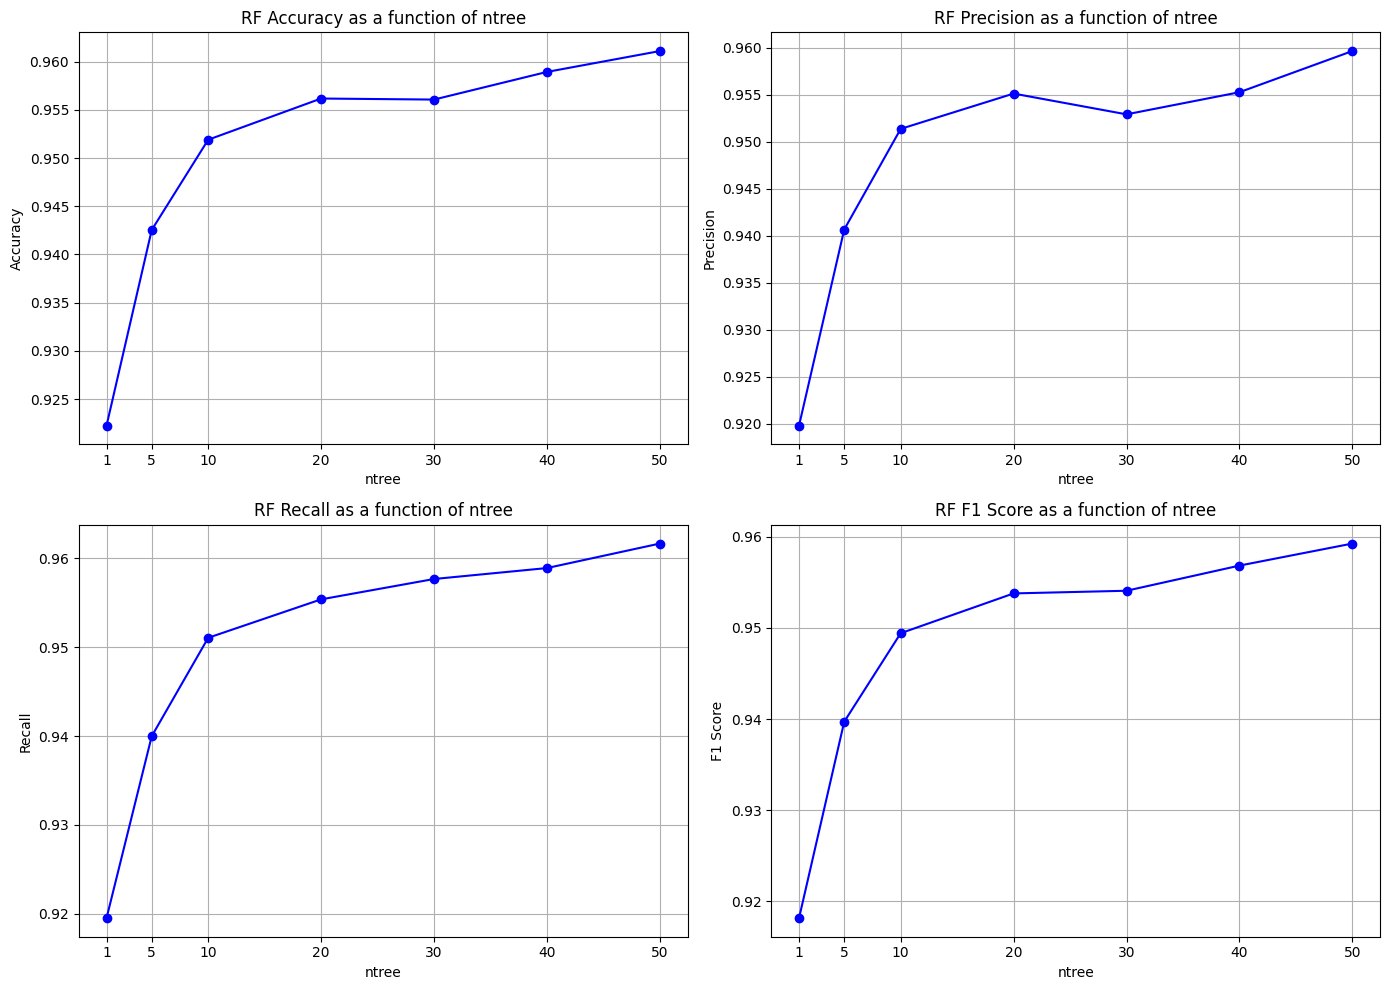

In [22]:
plot(metrics_results_2)

**4.** For each metric being evaluated (and for each dataset), discuss which value of ntree you would
select if you were to deploy this classifier in real life. Explain your reasoning.

So in this section of the notebook we're dealing with The 1984 United States Congressional Voting Dataset. Based on the metric results obtained above for each value of ntree and loking at the plots generated our primary goal is to understand how the number of trees (ntree) affects key performance metrics such as accuracy, precision, recall, and F1 score. Let's discuss for each metric being evaluated what value of ntree we would select if we were to deplot this in real life:

The highest accuracy is achieved at ntree = 50 with a score of 0.9611. This value of accuracy achieved is worth it since it doesn't take a lot of extra computational resources with the increase in the number of trees. Also in the context of voting it's important to have a high accuracy.

Precision peaks at ntree = 50 as well, with a score of 0.9596, indicating the model's high reliability in its positive predictions. Recall also reaches its highest at ntree = 50 with a score of 0.9617, also showing that the model's good at identifying all relevant instances of both classes. In the political context, ensuring high recall and high precision is very important to avoid misclassification of member's party affiliations, which could have potentially some negative consequences.

The F1 score, which balances precision and recall, is highest at ntree = 50 with a score of 0.9593, this is good since it shows that it doesn't favor either precision or recall which is important for a dataset where both identifying all members of a party correctly and ensuring the correctness of those identifications are equally important.

In conclusion, ntree = 50 emerges as the optimal choice for deployment based on our results, since it gives us the best overall performance. The trade-off here involves the computational cost and time associated with training and using a model with 50 trees. If predictions need to be made quickly or resources are limited one might consider a slightly lower ntree value that still offers high performance but at a lower computational cost. In this case, we migh consider ntree = 40 because of the reduction in computational demand giving us a quicker model training and prediction times without significantly sacrificing model performance.


*5.* Discuss (on a high level) which metrics were more directly affected by changing the value of
ntree and, more generally, how such changes affected the performance of your algorithm. For
instance: was the accuracy of the random forest particularly sensitive to increasing ntree past a
given value? Was the F1 score a “harder” metric to optimize, possibly requiring a significant
number of trees in the ensemble? Is there a point beyond which adding more trees does not
improve performance—or makes the performance worse?


Accuracy generally improved as ntree increased showing that adding more trees can enhance the model's overall ability to classify instances correctly. However, the rate of improvement tends to diminish beyond a certain point; but in this case and looking at our plots we didn't reach that point here since it performs best for ntree = 50.

Precision showed sensitivity to changes in ntree. Specifically, at ntree = 30, precision appeared to suffer more compared to other metrics possibly suggesting that precision might be more sensitive to the specific configuration of trees in the ensemble. The balancing act between adding more trees and the precision metric's performance underscores the complexity of optimizing for this specific metric.

Recall was generally less sensitive to increases in ntree compared to precision, maintaining a high level as more trees were added. This indicates that recall benefits from the diversity and robustness provided by a larger ensemble of trees.

Optimizing the F1 score, was challenging. While the F1 score improved with more trees, balancing the changes between both precision and recall was tricky here specially with precision being sensitive to ntree. The balance between not missing relevant instances and keeping the correctness of predictions however followed the general trend across the other metrics.

We can say ntree = 30 is a point where our model suffers a bit because of precision drop. However, there wasn't really a threshhold here where adding more trees didn't benefit performance. We just have to choose a number that balances those metrics keeping in mind computational cost
